In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit import rdBase
from rdkit import RDPaths
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import time
import glob, os, pickle
import random
from random import choices

In [2]:
## Load hits
total_hits = []
for file in glob.glob("./initial_hits.csv"): # switch to final_hits.csv for final set of hits
    fopen = open(file);
    for line in fopen.readlines():
        y = [value for value in line.split('\n')]
        y = y[0].split(",")
        try: 
            m = Chem.MolFromSmiles(y[0].replace('"',''))
            if m is not None:
                total_hits.append(m)
        except:
            x=1;
    fopen.close()

RDKit ERROR: [13:48:41] SMILES Parse Error: syntax error while parsing: SMILES
RDKit ERROR: [13:48:41] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'


In [3]:
## Check number of hits
len(total_hits)

2668

In [4]:
### User-defined parameters
N0 = 12 # Low atom threshold
N1 = 40 # High atom threshold
NUM_GROUPS = 5 # Number of different groupings to try
NUM_ITER = 500 # Number of pairs to test in each run


### Main grouping script ###
start_time = time.time()
TOPLIST = []
TOPLIST_IDX = []
ASSOCIATED_NUMs =[ ]
ASSOCIATED_MOLS=[]
HITS_LEFT=[]
TRIED = []

for IT in range(NUM_GROUPS):
    toplist = []
    toplist_idx = []
    hits_associated = []
    associated_nums = []
    associated_mols = []
    tried = []
    hits_left = [(total_hits[i],i) for i in range(0,len(total_hits))]

    for ITER in range(NUM_ITER):
        yy = random.sample(range(0, len(hits_left)), 2);
        if yy in tried:
            continue
        tried.append(yy)
        this_MCS = Chem.MolFromSmarts(rdFMCS.FindMCS([hits_left[x][0] for x in yy],timeout=1).smartsString);
        this_idx = [hits_left[x][1] for x in yy];

        if this_MCS.GetNumAtoms() < N0:
            continue
        toplist.append(this_MCS) # try out MCS
        toplist_idx.append(this_idx)
        associated_nums.append(0)
        associated_mols.append([])
        hits_left_update = []

        for i in range(len(hits_left)):
            res=rdFMCS.FindMCS([hits_left[i][0],toplist[-1]],timeout=1)
            if res.numAtoms >= N0 and res.numAtoms <= N1:
                associated_nums[-1] = associated_nums[-1] + 1
                associated_mols[-1].append(hits_left[i][1])
                hits_associated.append(hits_left[i][0])
            else:
                if hits_left[i][0].GetNumAtoms() >= 10:
                    hits_left_update.append(hits_left[i])

        if associated_nums[-1] == 0: # useless MCS
            associated_nums.pop()
            associated_mols.pop()
            toplist.pop()
            toplist_idx.pop()

        hits_left = hits_left_update

    TOPLIST.append(toplist)
    TOPLIST_IDX.append(toplist_idx)
    ASSOCIATED_NUMs.append(associated_nums)
    ASSOCIATED_MOLS.append(associated_mols)
    HITS_LEFT.append(hits_left)
    TRIED.append(tried)

print("--- %s seconds ---" % (time.time() - start_time))

--- 184.4535539150238 seconds ---


Number of hits: 2668
Number of associated hits in each group: [492, 38, 203, 171, 27, 194, 139, 94, 7, 112, 47, 27, 13, 80, 15, 10, 30, 8, 41, 11]
Total number of associated hits in all groups: 1759
Number of unassociated hits that can be associated: 838


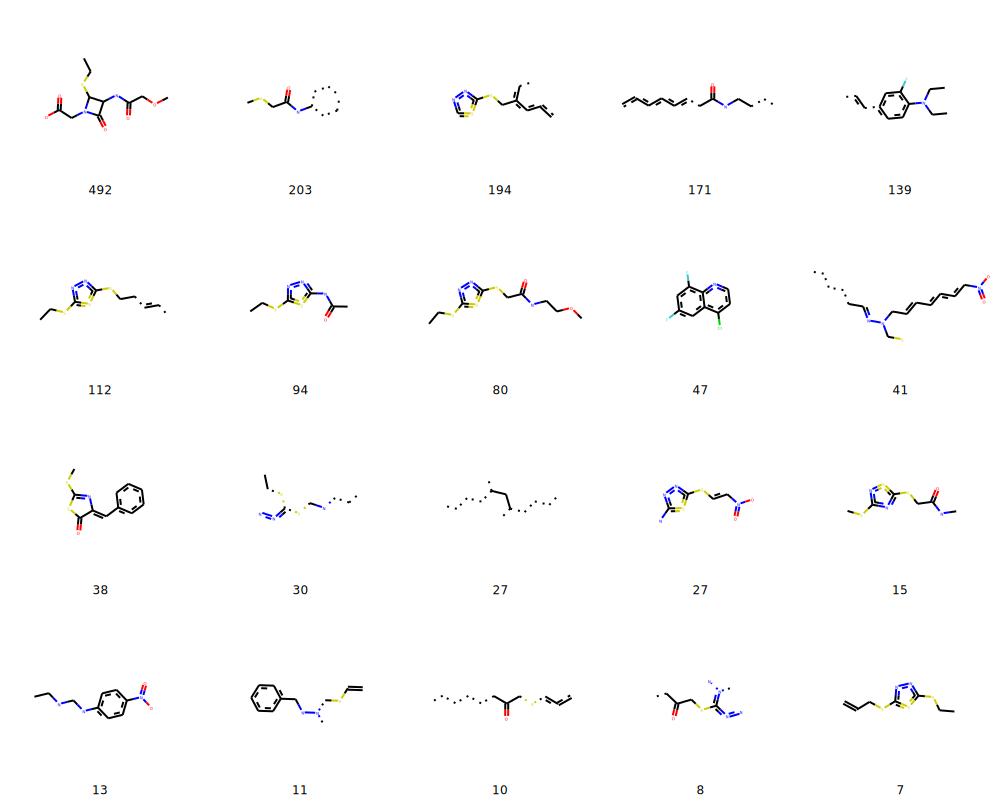

In [10]:
idx = 2 # Number of grouping to show, between 0 and NUM_GROUPS-1

### Show groups ###
toplist = TOPLIST[idx]
toplist_idx = TOPLIST_IDX[idx]
associated_nums = ASSOCIATED_NUMs[idx]
associated_mols = ASSOCIATED_MOLS[idx]
hits_left = HITS_LEFT[idx]

#print(ITER)
print("Number of hits:",len(total_hits))  # all mols
print("Number of associated hits in each group:", associated_nums)
print("Total number of associated hits in all groups:", sum(associated_nums)) # associated
print("Number of unassociated hits that can be associated:", len(hits_left)) # unassociated mols

redrawTL = []
for x in toplist_idx:
    ss = []
    for i in x:
        ss.append(total_hits[i])
    redrawTL.append(Chem.MolFromSmarts(rdFMCS.FindMCS(ss,timeout=1).smartsString))

srt=sorted(zip(associated_nums,range(len(associated_nums))),reverse=True)
Draw.DrawingOptions.atomLabelFontSize =30
img=Draw.MolsToGridImage([redrawTL[ss[1]] for ss in srt], molsPerRow=5,maxMols=1000,legends=[str(ss[0]) for ss in srt], useSVG=True)
img